#### By: Peyman Shahidi
#### Created: Oct 19, 2025
#### Last Edit: Oct 19, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots/anthropic_measure"

In [3]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [5]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,gpt4_exposure,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E2,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E2,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2


In [6]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


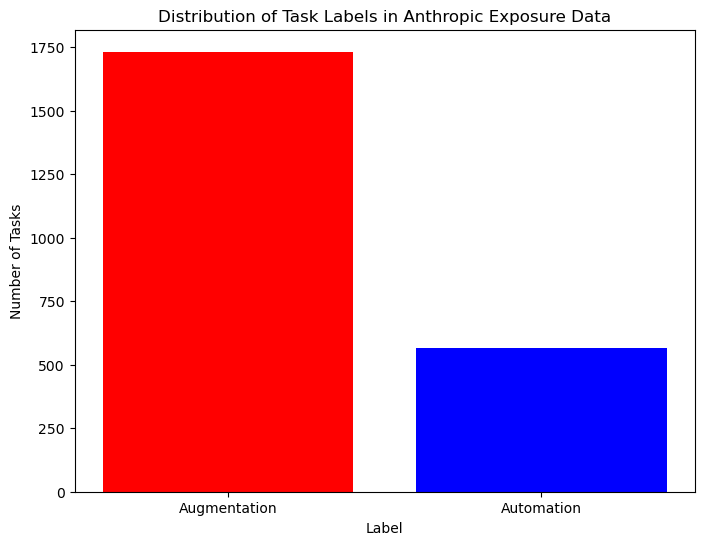

,task_name,automation,augmentation,label
0,act as advisers to student organizations.,0.38,0.36,Automation
1,act as an intermediary in negotiations between...,0.39,0.43,Augmentation
2,act as an intermediary in negotiations between...,0.39,0.38,Automation
3,act as liaisons between on-site managers or te...,0.56,0.00,Automation
4,adapt instructional content or delivery method...,0.29,0.70,Augmentation
...,...,...,...,...
2293,"write, prepare, and deliver statements for the...",0.00,0.79,Augmentation
2294,"write, present, and publish reports that recor...",0.51,0.47,Automation
2295,"write, review, or execute plans for testing ne...",0.40,0.00,Automation
2296,"write, review, or maintain engineering documen...",0.35,0.62,Augmentation


In [7]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

# Plot histogram of the label column to see share of each label
label_counts = anthropic_exposure['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['red', 'blue'])
plt.title('Distribution of Task Labels in Anthropic Exposure Data')
plt.xlabel('Label')
plt.ylabel('Number of Tasks')
# plt.savefig(f'{output_plot_path}/anthropic_exposure_label_distribution.png')
plt.show()

anthropic_exposure

In [8]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

merged_data.head()

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual


In [9]:
# Drop the supplemental tasks
merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

Number of matched tasks: 12,546
Distribution of labels in matched data:
label
Manual          11005
Augmentation     1136
Automation        405
Name: count, dtype: int64


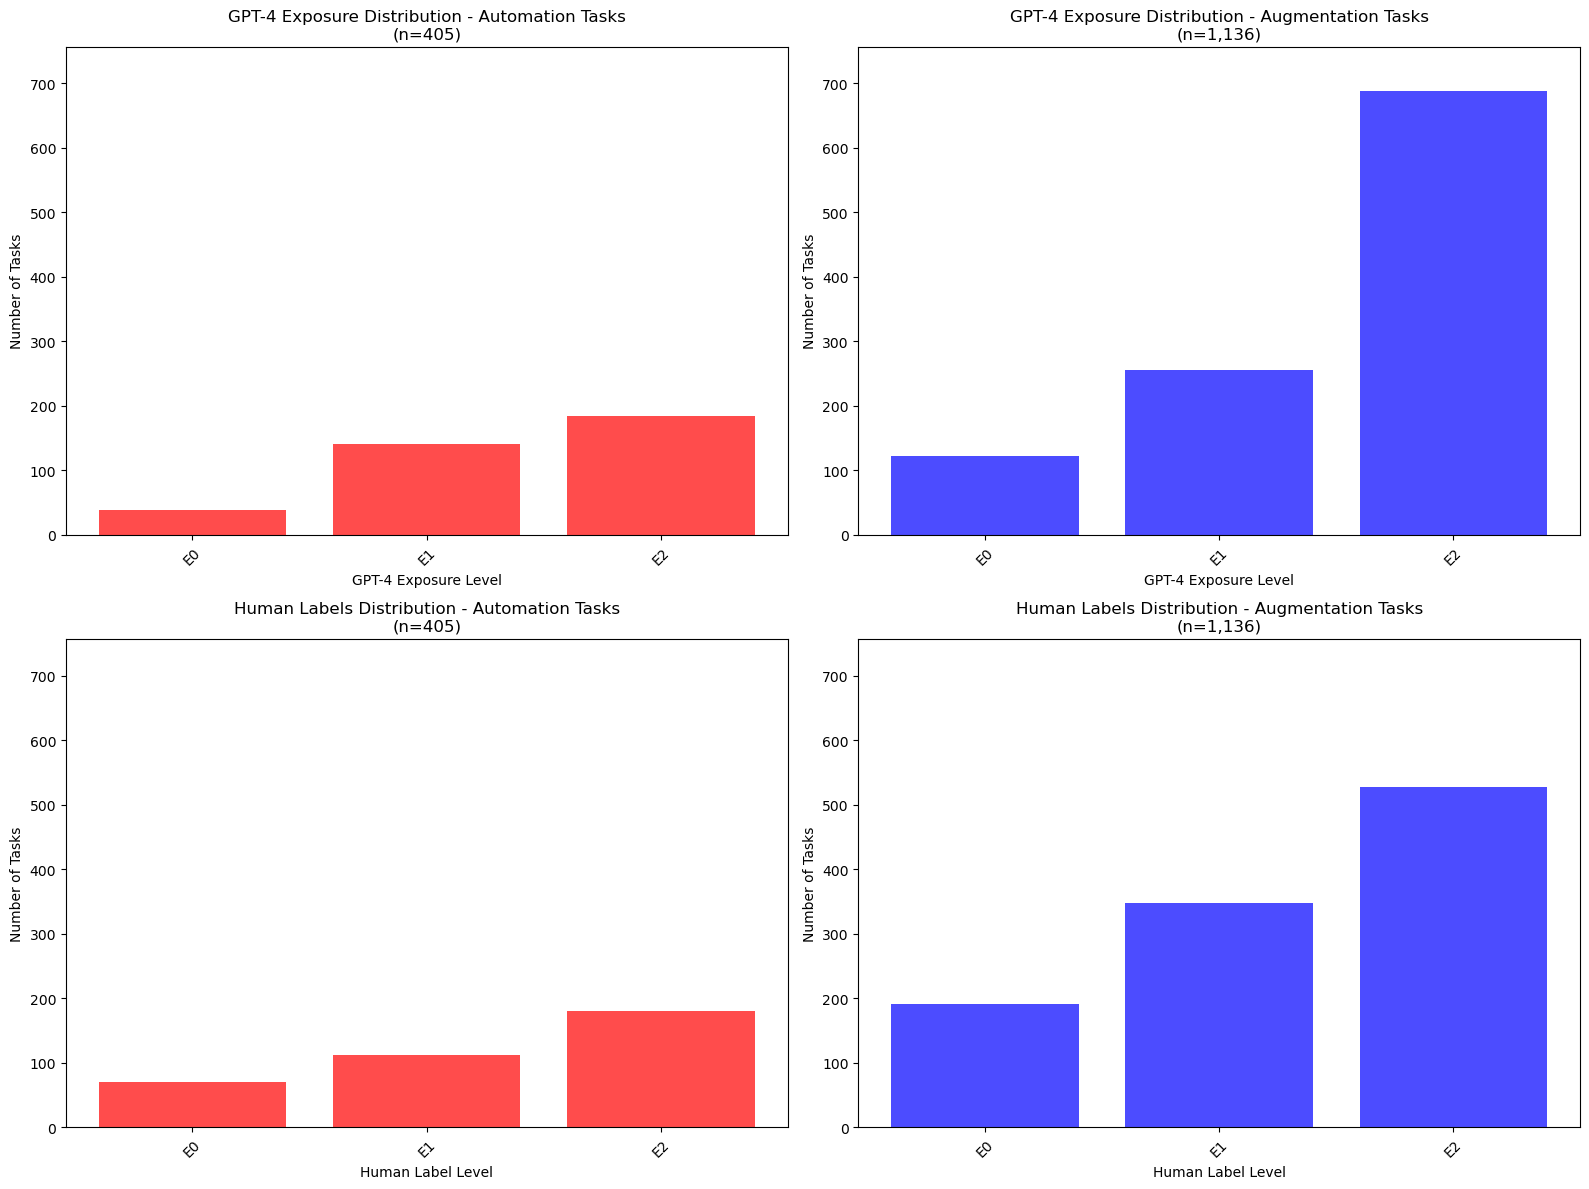


Summary by label:

Automation tasks: 405
  GPT-4 Exposure distribution:
    E0: 38 (9.4%)
    E1: 141 (34.8%)
    E2: 184 (45.4%)
  Human Labels distribution:
    E0: 71 (17.5%)
    E1: 112 (27.7%)
    E2: 180 (44.4%)

Augmentation tasks: 1,136
  GPT-4 Exposure distribution:
    E0: 123 (10.8%)
    E1: 256 (22.5%)
    E2: 688 (60.6%)
  Human Labels distribution:
    E0: 192 (16.9%)
    E1: 348 (30.6%)
    E2: 527 (46.4%)

Available columns in matched_data: ['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type', 'Job Zone', 'Task_Time_Percentage', 'Hourly_Mean_Wage', 'Hourly_P10_Wage', 'Hourly_P25_Wage', 'Hourly_Median_Wage', 'Hourly_P75_Wage', 'Hourly_P90_Wage', 'Annual_Mean_Wage', 'Annual_P10_Wage', 'Annual_P25_Wage', 'Annual_Median_Wage', 'Annual_P75_Wage', 'Annual_P90_Wage', 'FT_Daily', 'FT_Hourly or more', 'FT_More than monthly', 'FT_More than weekly', 'FT_More than yearly', 'FT_Several times daily', 'FT_Yearly or less', 'Importance', 'Relevance', 'Base_SOC_Co

In [10]:
# Plot histograms of gpt4_exposure and human_labels within Automation and Augmentation groups
# Filter out rows with missing labels (unmatched tasks)
matched_data = merged_data[merged_data['label'].notna()].copy()

print(f"Number of matched tasks: {len(matched_data):,}")
print(f"Distribution of labels in matched data:")
print(matched_data['label'].value_counts())

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define colors for each group
colors = {'Automation': 'red', 'Augmentation': 'blue'}

# Collect all y-values to determine global y-axis scale
all_y_values = []

# Top row: gpt4_exposure distributions
if 'gpt4_exposure' in matched_data.columns:
    for i, label in enumerate(['Automation', 'Augmentation']):
        subset = matched_data[matched_data['label'] == label]
        if len(subset) > 0:
            gpt4_counts = subset['gpt4_exposure'].value_counts().sort_index()
            all_y_values.extend(gpt4_counts.values)

# Bottom row: human_labels distributions  
if 'human_labels' in matched_data.columns:
    for i, label in enumerate(['Automation', 'Augmentation']):
        subset = matched_data[matched_data['label'] == label]
        if len(subset) > 0:
            human_counts = subset['human_labels'].value_counts().sort_index()
            all_y_values.extend(human_counts.values)

# Calculate global y-axis limits with some padding
if all_y_values:
    max_y = max(all_y_values)
    y_limit = max_y * 1.1  # Add 10% padding
else:
    y_limit = 100  # Default fallback

# Top row: gpt4_exposure distributions
if 'gpt4_exposure' in matched_data.columns:
    for i, label in enumerate(['Automation', 'Augmentation']):
        ax = axes[0, i]
        subset = matched_data[matched_data['label'] == label]
        
        if len(subset) > 0:
            gpt4_counts = subset['gpt4_exposure'].value_counts().sort_index()
            ax.bar(gpt4_counts.index, gpt4_counts.values, color=colors[label], alpha=0.7)
            ax.set_title(f'GPT-4 Exposure Distribution - {label} Tasks\n(n={len(subset):,})')
            ax.set_xlabel('GPT-4 Exposure Level')
            ax.set_ylabel('Number of Tasks')
            ax.tick_params(axis='x', rotation=45)
            ax.set_ylim(0, y_limit)
        else:
            ax.text(0.5, 0.5, f'No {label} tasks found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'GPT-4 Exposure - {label} (No Data)')
else:
    for i in range(2):
        axes[0, i].text(0.5, 0.5, 'gpt4_exposure column not found', ha='center', va='center', transform=axes[0, i].transAxes)
        axes[0, i].set_title('GPT-4 Exposure - Column Not Found')

# Bottom row: human_labels distributions
if 'human_labels' in matched_data.columns:
    for i, label in enumerate(['Automation', 'Augmentation']):
        ax = axes[1, i]
        subset = matched_data[matched_data['label'] == label]
        
        if len(subset) > 0:
            human_counts = subset['human_labels'].value_counts().sort_index()
            ax.bar(human_counts.index, human_counts.values, color=colors[label], alpha=0.7)
            ax.set_title(f'Human Labels Distribution - {label} Tasks\n(n={len(subset):,})')
            ax.set_xlabel('Human Label Level')
            ax.set_ylabel('Number of Tasks')
            ax.tick_params(axis='x', rotation=45)
            ax.set_ylim(0, y_limit)
        else:
            ax.text(0.5, 0.5, f'No {label} tasks found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Human Labels - {label} (No Data)')
else:
    for i in range(2):
        axes[1, i].text(0.5, 0.5, 'human_labels column not found', ha='center', va='center', transform=axes[1, i].transAxes)
        axes[1, i].set_title('Human Labels - Column Not Found')

plt.tight_layout()
plt.savefig(f'{output_plot_path}/exposure_histograms_by_label.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"\nSummary by label:")
for label in ['Automation', 'Augmentation']:
    subset = matched_data[matched_data['label'] == label]
    print(f"\n{label} tasks: {len(subset):,}")
    
    if 'gpt4_exposure' in matched_data.columns and len(subset) > 0:
        print(f"  GPT-4 Exposure distribution:")
        gpt4_dist = subset['gpt4_exposure'].value_counts().sort_index()
        for exp_level, count in gpt4_dist.items():
            print(f"    {exp_level}: {count:,} ({count/len(subset)*100:.1f}%)")
    
    if 'human_labels' in matched_data.columns and len(subset) > 0:
        print(f"  Human Labels distribution:")
        human_dist = subset['human_labels'].value_counts().sort_index()
        for human_level, count in human_dist.items():
            print(f"    {human_level}: {count:,} ({count/len(subset)*100:.1f}%)")

# Print available columns for debugging
print(f"\nAvailable columns in matched_data: {list(matched_data.columns)}")
print(f"Y-axis limit set to: {y_limit:.0f}")

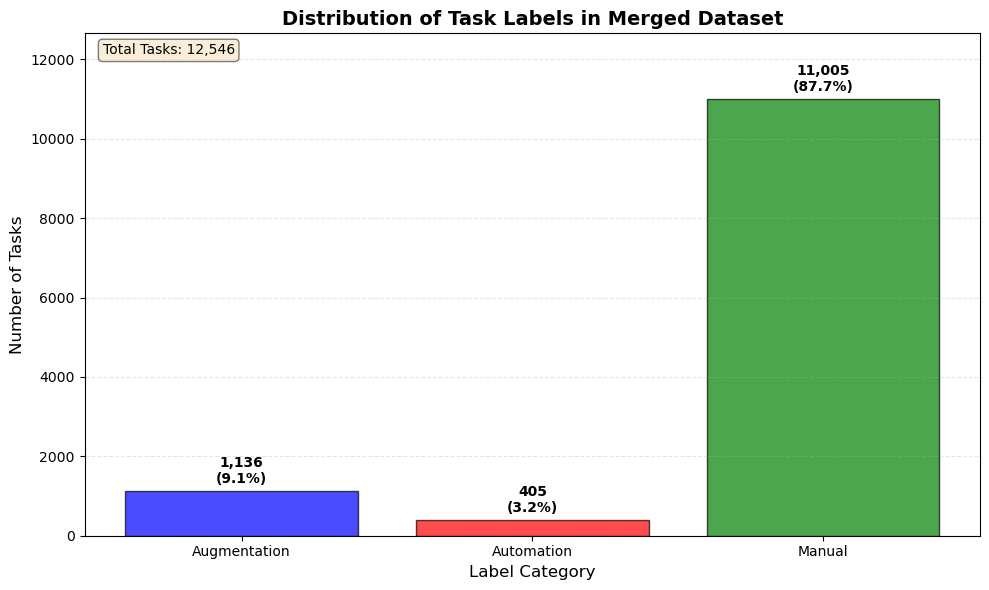

Detailed Label Distribution:
Automation  :     405 tasks (  3.2%)
Augmentation:   1,136 tasks (  9.1%)
Manual      :  11,005 tasks ( 87.7%)
Total       :  12,546 tasks (100.0%)


In [11]:
# Plot histogram of all three label values in a single histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get the distribution of all label values
label_counts = merged_data['label'].value_counts().sort_index()

# Define colors for each category
colors = {'Automation': 'red', 'Augmentation': 'blue', 'Manual': 'green'}

# Create the bar plot
bars = ax.bar(label_counts.index, label_counts.values, 
              color=[colors[label] for label in label_counts.index], 
              alpha=0.7, edgecolor='black', linewidth=1)

# Add value labels on top of each bar
for i, (label, count) in enumerate(label_counts.items()):
    percentage = (count / len(merged_data)) * 100
    ax.text(i, count + max(label_counts.values) * 0.01, 
            f'{count:,}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontweight='bold')

# Customize the plot
ax.set_title('Distribution of Task Labels in Merged Dataset', fontsize=14, fontweight='bold')
ax.set_xlabel('Label Category', fontsize=12)
ax.set_ylabel('Number of Tasks', fontsize=12)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Set y-axis limit with some padding
ax.set_ylim(0, max(label_counts.values) * 1.15)

# Add total count in the plot
total_tasks = len(merged_data)
ax.text(0.02, 0.98, f'Total Tasks: {total_tasks:,}', 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{output_plot_path}/all_labels_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("Detailed Label Distribution:")
print("=" * 40)
for label in ['Automation', 'Augmentation', 'Manual']:
    count = label_counts.get(label, 0)
    percentage = (count / total_tasks) * 100
    print(f"{label:12}: {count:7,} tasks ({percentage:5.1f}%)")
print("=" * 40)
print(f"{'Total':12}: {total_tasks:7,} tasks (100.0%)")

### Plot number of unique tasks in occupation against share of Manual/Augmented/Automation task

In [12]:
# Create occupation-level analysis for scatter plots
# Group by occupation and calculate label fractions and task counts
occupation_stats = []

for (soc_code, occ_title), group in merged_data.groupby(['O*NET-SOC Code', 'Occupation Title']):
    num_tasks = group['Task ID'].nunique()
    total_tasks = len(group)
    
    manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
    augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
    automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
    ai_fraction = augmentation_fraction + automation_fraction
    
    occupation_stats.append({
        'O*NET-SOC Code': soc_code,
        'Occupation Title': occ_title,
        'num_tasks': num_tasks,
        'manual_fraction': manual_fraction,
        'ai_fraction': ai_fraction,
        'augmentation_fraction': augmentation_fraction,
        'automation_fraction': automation_fraction
    })

occupation_analysis = pd.DataFrame(occupation_stats)

# save occupation analysis to CSV
occupation_analysis.to_csv(f'{output_data_path}/occupation_level_anthropic_exposure_analysis.csv', index=False)

print(f"Number of occupations: {len(occupation_analysis):,}")
print(f"Range of tasks per occupation: {occupation_analysis['num_tasks'].min()} - {occupation_analysis['num_tasks'].max()}")
print(f"\nSample of occupation analysis:")
occupation_analysis.head()

Number of occupations: 837
Range of tasks per occupation: 1 - 38

Sample of occupation analysis:


,O*NET-SOC Code,Occupation Title,num_tasks,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction
0,11-1011.00,Chief Executives,19,0.68,0.32,0.32,0.00
1,11-1011.03,Chief Sustainability Officers,18,0.72,0.28,0.28,0.00
2,11-1021.00,General and Operations Managers,9,0.89,0.11,0.11,0.00
3,11-2011.00,Advertising and Promotions Managers,13,0.85,0.15,0.15,0.00
4,11-2021.00,Marketing Managers,12,0.67,0.33,0.33,0.00


In [13]:
occupation_analysis.sort_values(by='ai_fraction', ascending=False).head(10)

,O*NET-SOC Code,Occupation Title,num_tasks,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction
121,15-2099.01,Bioinformatics Technicians,11,0.18,0.82,0.55,0.27
103,15-1243.01,Data Warehousing Specialists,18,0.28,0.72,0.67,0.06
215,19-3093.00,Historians,17,0.29,0.71,0.47,0.24
105,15-1251.00,Computer Programmers,13,0.31,0.69,0.38,0.31
816,53-6041.00,Traffic Technicians,3,0.33,0.67,0.67,0.00
305,27-3043.00,Writers and Authors,6,0.33,0.67,0.67,0.00
95,15-1212.00,Information Security Analysts,11,0.36,0.64,0.64,0.00
251,23-1022.00,"Arbitrators, Mediators, and Conciliators",11,0.36,0.64,0.45,0.18
279,27-1013.00,"Fine Artists, Including Painters, Sculptors, a...",8,0.38,0.62,0.50,0.12
155,17-2199.06,Microsystems Engineers,8,0.38,0.62,0.38,0.25


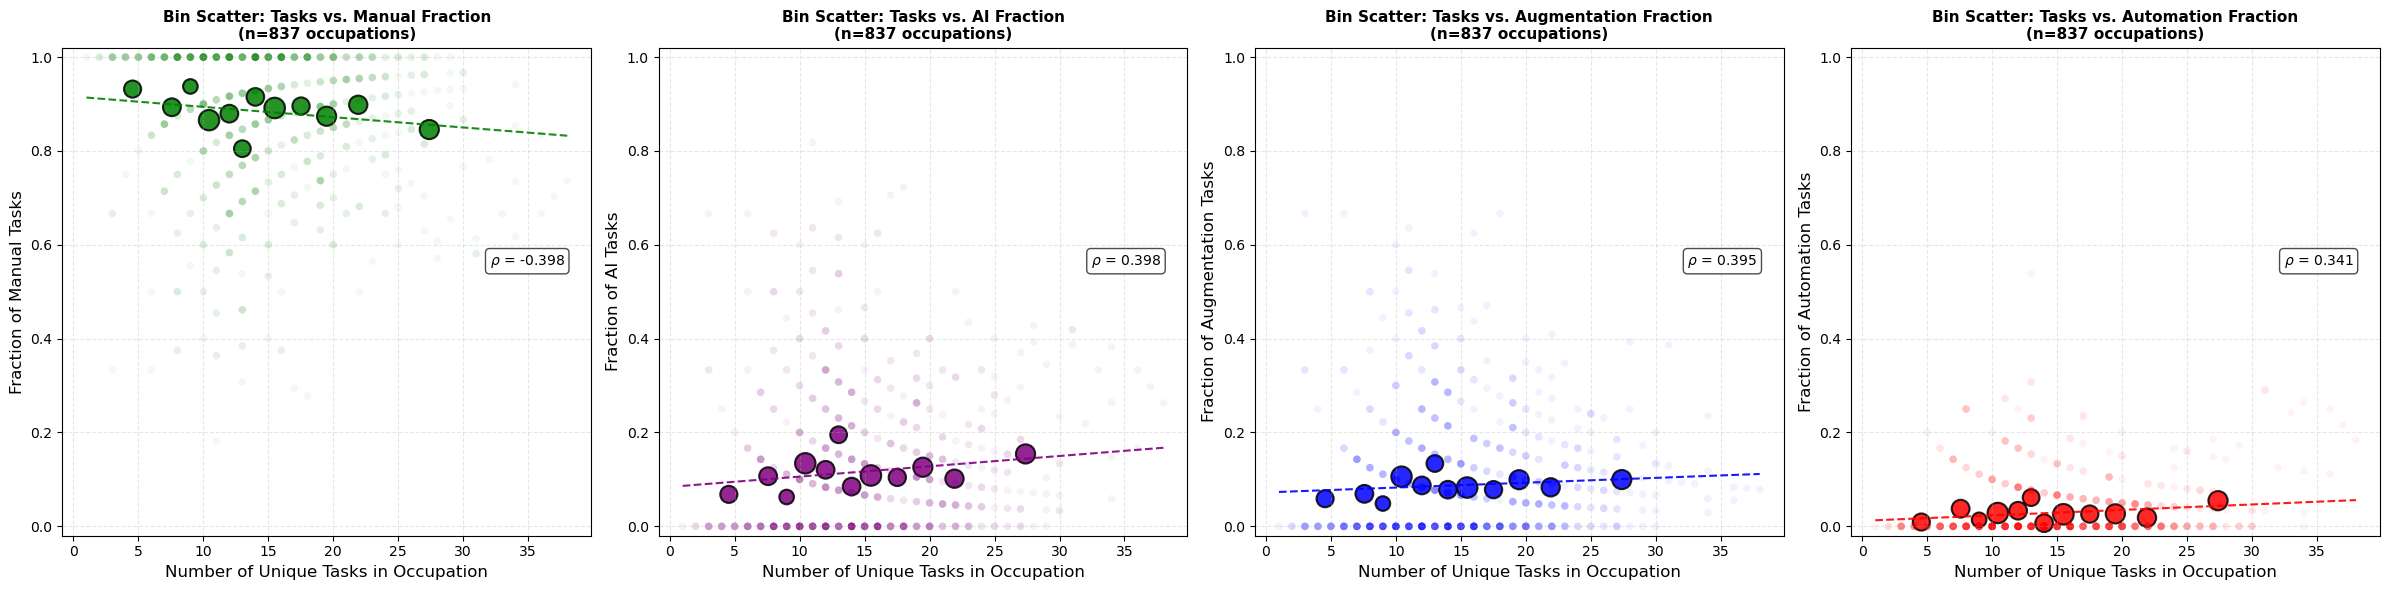

In [14]:
# Bin scatter plot: Number of unique tasks in occupation vs. label fractions (Manual, AI, Augmentation, Automation)
import scipy.stats as stats

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Define bin edges and configs (binning on x = num_tasks, proportional bins by quantiles)
num_bins = 12
x = occupation_analysis['num_tasks'].values
x_min, x_max = x.min(), x.max()
# Use quantile-based bins for proportional bin sizes
bin_edges = np.unique(np.quantile(x, np.linspace(0, 1, num_bins + 1)))
plot_configs = [
    ('manual_fraction', 'Manual', 'green'),
    ('ai_fraction', 'AI', 'purple'),
    ('augmentation_fraction', 'Augmentation', 'blue'), 
    ('automation_fraction', 'Automation', 'red')
]

for i, (fraction_col, label, color) in enumerate(plot_configs):
    ax = axes[i]
    y = occupation_analysis[fraction_col].values

    # Add fitted regression line (global)
    if len(x) > 1 and np.std(x) > 0:
        coeffs = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(coeffs)
        x_fit = np.linspace(x.min(), x.max(), 100)
        y_fit = fit_fn(x_fit)
        ax.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=1.5, alpha=0.9, zorder=2)

    # Bin the x values using quantile-based bins
    bin_indices = np.digitize(x, bin_edges, right=True) - 1
    bin_means_x = []
    bin_means_y = []
    bin_counts = []
    for b in range(len(bin_edges) - 1):
        in_bin = (x >= bin_edges[b]) & (x < bin_edges[b + 1])
        if b == len(bin_edges) - 2:
            # Include right edge in last bin
            in_bin = (x >= bin_edges[b]) & (x <= bin_edges[b + 1])
        if np.any(in_bin):
            bin_means_x.append(x[in_bin].mean())
            bin_means_y.append(y[in_bin].mean())
            bin_counts.append(in_bin.sum())

    # Scale marker size by relative bin count
    total_obs = len(x)
    min_size = 60
    max_size = 220
    sizes = [min_size + (max_size - min_size) * (bc / max(bin_counts)) for bc in bin_counts] if bin_counts else []

    # Plot bin means as large points (size proportional to bin count)
    ax.scatter(bin_means_x, bin_means_y, color=color, s=sizes, alpha=0.85, edgecolors='black', linewidth=1.5, label=f'Bin Means ({label})')

    # Optionally plot all points in background (faded)
    ax.scatter(x, y, color=color, s=30, alpha=0.05, edgecolors='none')

    # Customize subplot
    ax.set_xlabel('Number of Unique Tasks in Occupation', fontsize=12)
    ax.set_ylabel(f'Fraction of {label} Tasks', fontsize=12)
    ax.set_title(f'Bin Scatter: Tasks vs. {label} Fraction\n(n={len(occupation_analysis):,} occupations)', fontsize=11, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xlim(x_min - (x_max - x_min) * 0.05, x_max + (x_max - x_min) * 0.05)
    ax.set_ylim(-0.02, 1.02)

    # Add correlation coefficient for bin means
    if len(bin_means_x) > 1:
        correlation = np.corrcoef(bin_means_x, bin_means_y)[0, 1]
        ax.text(0.95, 0.58, r'$\rho$' +f' = {correlation:.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig(f'{output_plot_path}/occupation_tasks_vs_label_fractions_bin_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

### Analysis by SOC Hierarchy Levels

Now let's repeat the same analysis for different levels of the SOC (Standard Occupational Classification) hierarchy:
- **Major Group**: 2-digit SOC codes (e.g., 11 = Management Occupations)
- **Minor Group**: 4-digit SOC codes (e.g., 11-10 = Top Executives) 
- **Broad Occupation**: 6-digit SOC codes (e.g., 11-1011 = Chief Executives)
- **Detailed Occupation**: Full SOC codes (e.g., 11-1011.00 = Chief Executives)

In [15]:
# Create SOC hierarchy levels from the O*NET-SOC Code
merged_data['major_group'] = merged_data['O*NET-SOC Code'].str[:2]
merged_data['minor_group'] = merged_data['O*NET-SOC Code'].str[:5] 
merged_data['broad_occupation'] = merged_data['O*NET-SOC Code'].str[:8]
merged_data['detailed_occupation'] = merged_data['O*NET-SOC Code']

# Function to analyze any grouping level
def analyze_grouping_level(data, group_col, level_name):
    """
    Analyze task fractions and counts at any grouping level
    """
    group_stats = []
    
    for group_code, group_data in data.groupby(group_col):
        num_tasks = group_data['Task ID'].nunique()
        total_tasks = len(group_data)
        
        manual_fraction = (group_data['label'] == 'Manual').sum() / total_tasks
        augmentation_fraction = (group_data['label'] == 'Augmentation').sum() / total_tasks  
        automation_fraction = (group_data['label'] == 'Automation').sum() / total_tasks
        # AI fraction is the sum of augmentation and automation fractions
        ai_fraction = augmentation_fraction + automation_fraction
        
        group_stats.append({
            'group_code': group_code,
            'level_name': level_name,
            'num_tasks': num_tasks,
            'manual_fraction': manual_fraction,
            'augmentation_fraction': augmentation_fraction,
            'automation_fraction': automation_fraction,
            'ai_fraction': ai_fraction
        })
    
    return pd.DataFrame(group_stats)

# Analyze all levels
soc_levels = [
    ('major_group', 'Major Group'),
    ('minor_group', 'Minor Group'), 
    ('broad_occupation', 'Broad Occupation'),
    ('detailed_occupation', 'Detailed Occupation')
]

all_analyses = []
for col, name in soc_levels:
    analysis = analyze_grouping_level(merged_data, col, name)
    all_analyses.append(analysis)
    print(f"{name}: {len(analysis)} groups, {analysis['num_tasks'].min()}-{analysis['num_tasks'].max()} tasks per group")

# Combine all analyses
combined_analysis = pd.concat(all_analyses, ignore_index=True)
print(f"\nTotal analysis records: {len(combined_analysis)}")
combined_analysis.head(10)

Major Group: 22 groups, 85-1332 tasks per group
Minor Group: 108 groups, 7-426 tasks per group
Broad Occupation: 723 groups, 1-130 tasks per group
Detailed Occupation: 837 groups, 1-38 tasks per group

Total analysis records: 1690
Detailed Occupation: 837 groups, 1-38 tasks per group

Total analysis records: 1690


,group_code,level_name,num_tasks,manual_fraction,augmentation_fraction,automation_fraction,ai_fraction
0,11,Major Group,843,0.88,0.10,0.02,0.12
1,13,Major Group,675,0.80,0.15,0.06,0.20
2,15,Major Group,547,0.62,0.32,0.07,0.38
3,17,Major Group,903,0.88,0.09,0.03,0.12
4,19,Major Group,869,0.79,0.17,0.04,0.21
5,21,Major Group,214,0.82,0.15,0.03,0.18
6,23,Major Group,85,0.73,0.19,0.08,0.27
7,25,Major Group,543,0.72,0.11,0.17,0.28
8,27,Major Group,517,0.81,0.12,0.07,0.19
9,29,Major Group,1332,0.89,0.10,0.01,0.11


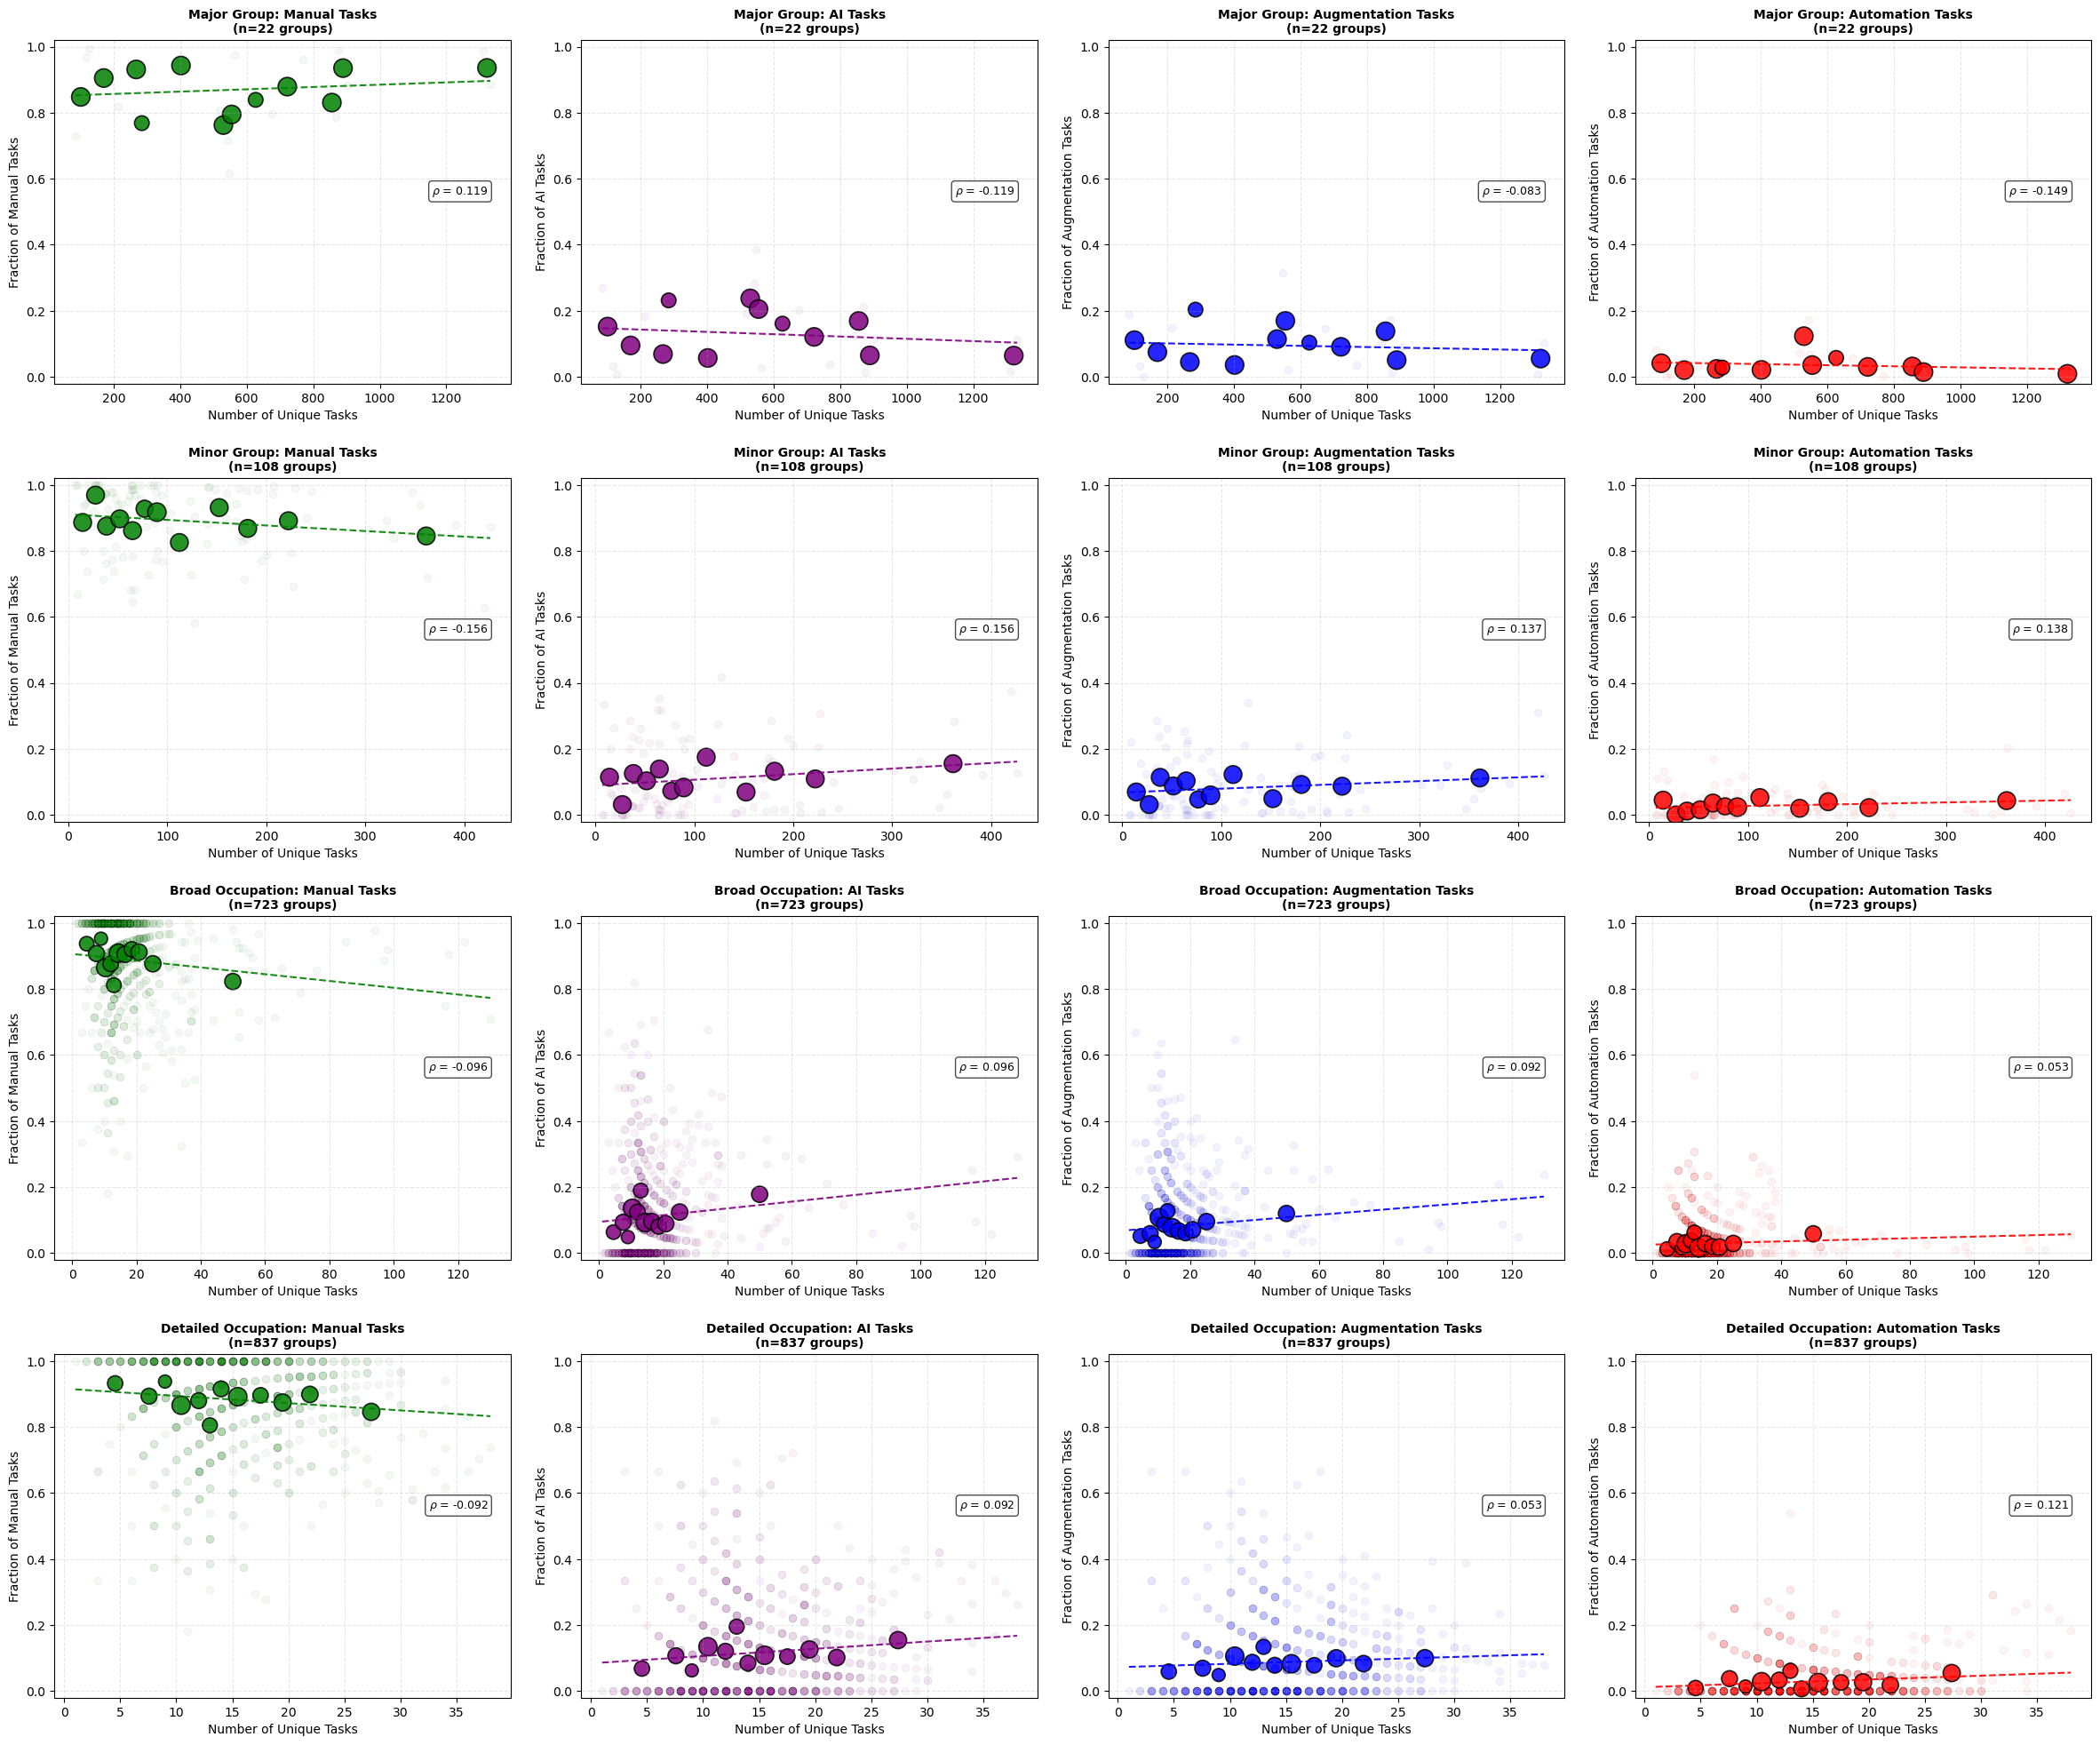

In [16]:
# Create a 4x4 figure showing scatter plots for all SOC levels with bin means (bins on x = num_tasks)
fig, axes = plt.subplots(4, 4, figsize=(24, 20))

# Define colors and labels for each plot (insert AI between Manual and Augmentation)
plot_configs = [
    ('manual_fraction', 'Manual', 'green'),
    ('ai_fraction', 'AI', 'purple'),
    ('augmentation_fraction', 'Augmentation', 'blue'), 
    ('automation_fraction', 'Automation', 'red')
]

# Bins for num_tasks axis (x) - use quantile bins for proportional bin sizes
num_bins = 12

# Plot for each SOC level
for row, (col, level_name) in enumerate(soc_levels):
    # Get data for this level
    level_data = all_analyses[row]
    if len(level_data) == 0:
        continue

    # Use quantile-based bin edges so each bin has roughly equal observations
    x = level_data['num_tasks'].values
    x_min, x_max = x.min(), x.max()
    bin_edges = np.unique(np.quantile(x, np.linspace(0, 1, num_bins + 1)))
    
    # Create scatter plots for each task type
    for col_idx, (fraction_col, label, color) in enumerate(plot_configs):
        ax = axes[row, col_idx]
        x = level_data['num_tasks'].values
        y = level_data[fraction_col].values
        
        # Scatter plot
        scatter = ax.scatter(x, y, alpha=0.05, color=color, s=40, edgecolors='black', linewidth=0.5)
        
        # Add fitted regression line (global only)
        if len(x) > 1 and np.std(x) > 0:
            coeffs = np.polyfit(x, y, 1)
            fit_fn = np.poly1d(coeffs)
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = fit_fn(x_fit)
            ax.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=1.5, alpha=0.9, zorder=2)
        
        # Bin the x axis and overlay bin means (no bin-fitted line)
        bin_indices = np.digitize(x, bin_edges, right=True) - 1
        bin_means_x = []
        bin_means_y = []
        bin_counts = []
        for b in range(len(bin_edges) - 1):
            in_bin = (x >= bin_edges[b]) & (x < bin_edges[b + 1])
            if b == len(bin_edges) - 2:
                # Include right edge in last bin
                in_bin = (x >= bin_edges[b]) & (x <= bin_edges[b + 1])
            if np.any(in_bin):
                bin_means_x.append(x[in_bin].mean())
                bin_means_y.append(y[in_bin].mean())
                bin_counts.append(in_bin.sum())
        
        # Scale marker sizes by bin counts
        min_size = 60
        max_size = 220
        sizes = [min_size + (max_size - min_size) * (bc / max(bin_counts)) for bc in bin_counts] if bin_counts else []
        
        if bin_means_x:
            ax.scatter(bin_means_x, bin_means_y, color=color, s=sizes, alpha=0.85, edgecolors='black', linewidth=1.2)
        
        # Customize each subplot
        ax.set_xlabel('Number of Unique Tasks', fontsize=10)
        ax.set_ylabel(f'Fraction of {label} Tasks', fontsize=10)
        ax.set_title(f'{level_name}: {label} Tasks\n(n={len(level_data):,} groups)', fontsize=10, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_ylim(-0.02, 1.02)
        x_padding = max(1, (x_max - x_min) * 0.05)
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        correlation = level_data[fraction_col].corr(level_data['num_tasks'])
        ax.text(0.95, 0.58, r'$\rho$' +f' = {correlation:.3f}', transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout(pad=2.0)
plt.savefig(f'{output_plot_path}/soc_hierarchy_tasks_vs_label_fractions.png', dpi=300, bbox_inches='tight')
# plt.show()

In [17]:
# Create separate figure sets highlighting each major group one at a time with bin means (bins on x=num_tasks)

# Run flag: set to True to generate all figures, False to skip heavy loop.
RUN_HIGHLIGHT_LOOP = True  # change to True when you want to generate all figures
TEST_HIGHLIGHT_MG = '11'    # a single major group to generate when RUN_HIGHLIGHT_LOOP is False

# Get unique major groups
unique_major_groups = sorted(merged_data['major_group'].unique())
print(f"Will create up to {len(unique_major_groups)} separate figure sets (save-only).")

# Map major group codes to readable names (short mapping; extend as needed)
major_group_names = {
    '11': 'Management Occupations',
    '13': 'Business and Financial Operations',
    '15': 'Computer and Mathematical Occupations',
    '17': 'Architecture and Engineering',
    '19': 'Life, Physical, and Social Science',
    '21': 'Community and Social Service',
    '23': 'Legal Occupations',
    '25': 'Educational Instruction and Library',
    '27': 'Arts, Design, Entertainment, Sports, and Media',
    '29': 'Healthcare Practitioners and Technical',
    '31': 'Healthcare Support',
    '33': 'Protective Service',
    '35': 'Food Preparation and Serving Related',
    '37': 'Building and Grounds Cleaning and Maintenance',
    '39': 'Personal Care and Service',
    '41': 'Sales and Related',
    '43': 'Office and Administrative Support',
    '45': 'Farming, Fishing, and Forestry',
    '47': 'Construction and Extraction',
    '49': 'Installation, Maintenance, and Repair',
    '51': 'Production',
    '53': 'Transportation and Material Moving'
}

# Add major group information to each analysis level (if not already done)
for i, (col, level_name) in enumerate(soc_levels):
    level_data = all_analyses[i]
    if 'major_group' not in level_data.columns:
        level_data['major_group'] = level_data['group_code'].str[:2]

# Define task type configurations (include AI)
plot_configs = [
    ('manual_fraction', 'Manual', 'green'),
    ('ai_fraction', 'AI', 'purple'),
    ('augmentation_fraction', 'Augmentation', 'blue'), 
    ('automation_fraction', 'Automation', 'red')
]

# Bins for x axis
num_bins = 12

# Determine which major groups to iterate over
if RUN_HIGHLIGHT_LOOP:
    iter_mgs = unique_major_groups
else:
    iter_mgs = [TEST_HIGHLIGHT_MG]

# Loop through each major group to create highlighted figures (save-only)
for highlight_mg in iter_mgs:
    mg_name = major_group_names.get(highlight_mg, f'Major Group {highlight_mg}')
    print(f"Preparing figure for: MG {highlight_mg} - {mg_name}")
    
    # Create a 4x4 figure for this major group
    fig, axes = plt.subplots(4, 4, figsize=(24, 20))
    
    # Plot for each SOC level
    for row, (col, level_name) in enumerate(soc_levels):
        level_data = all_analyses[row]
        if len(level_data) == 0:
            continue
        x = level_data['num_tasks'].values
        x_min, x_max = x.min(), x.max()
        # Use quantile bins for proportional bin sizes
        bin_edges = np.unique(np.quantile(x, np.linspace(0, 1, num_bins + 1)))
        
        # Create scatter plots for each task type
        for col_idx, (fraction_col, label, base_color) in enumerate(plot_configs):
            ax = axes[row, col_idx]
            x = level_data['num_tasks'].values
            y = level_data[fraction_col].values
            
            # Plot all data points in muted gray
            ax.scatter(x, y, alpha=0.35, color='lightgray', s=30, edgecolors='none')
            
            # Then highlight the specific major group in yellow
            highlight_mask = level_data['major_group'] == highlight_mg
            if highlight_mask.sum() > 0:
                subset_data = level_data[highlight_mask]
                ax.scatter(subset_data['num_tasks'].values, subset_data[fraction_col].values, alpha=0.95, color='yellow', s=50, edgecolors='red', linewidth=0.8)
            
            # Add fitted regression line for all data points
            if len(x) > 1 and np.std(x) > 0:
                coeffs = np.polyfit(x, y, 1)
                fit_fn = np.poly1d(coeffs)
                x_fit = np.linspace(x.min(), x.max(), 100)
                y_fit = fit_fn(x_fit)
                ax.plot(x_fit, y_fit, color=base_color, linestyle='--', linewidth=1.5, alpha=0.9, zorder=2)
            
            # Add fitted regression line for highlighted major group (if any)
            if highlight_mask.sum() > 1:
                x_hl = subset_data['num_tasks'].values
                y_hl = subset_data[fraction_col].values
                if np.std(x_hl) > 0:
                    coeffs_hl = np.polyfit(x_hl, y_hl, 1)
                    fit_fn_hl = np.poly1d(coeffs_hl)
                    x_fit_hl = np.linspace(x_hl.min(), x_hl.max(), 100)
                    y_fit_hl = fit_fn_hl(x_fit_hl)
                    ax.plot(x_fit_hl, y_fit_hl, color='orange', linestyle='-', linewidth=2.0, alpha=0.9, zorder=3)
            
            # Bin the x values and overlay bin means (no bin-fitted line)
            bin_indices = np.digitize(x, bin_edges, right=True) - 1
            bin_means_x = []
            bin_means_y = []
            bin_counts = []
            for b in range(len(bin_edges) - 1):
                in_bin = (x >= bin_edges[b]) & (x < bin_edges[b + 1])
                if b == len(bin_edges) - 2:
                    in_bin = (x >= bin_edges[b]) & (x <= bin_edges[b + 1])
                if np.any(in_bin):
                    bin_means_x.append(x[in_bin].mean())
                    bin_means_y.append(y[in_bin].mean())
                    bin_counts.append(in_bin.sum())
            
            # Scale marker sizes by bin counts
            min_size = 60
            max_size = 220
            sizes = [min_size + (max_size - min_size) * (bc / max(bin_counts)) for bc in bin_counts] if bin_counts else []
            
            if bin_means_x:
                ax.scatter(bin_means_x, bin_means_y, color=base_color, s=sizes, alpha=0.9, edgecolors='black', linewidth=1.2)
            
            # Customize each subplot
            ax.set_xlabel('Number of Unique Tasks', fontsize=11)
            ax.set_ylabel(f'Fraction of {label} Tasks', fontsize=11)
            ax.set_title(f'{level_name}: {label} Tasks\n(n={len(level_data):,} total groups)', fontsize=10, fontweight='bold')
            ax.grid(True, linestyle='--', alpha=0.25)
            ax.set_xlim(x_min - max(1, (x_max - x_min) * 0.05), x_max + max(1, (x_max - x_min) * 0.05))
            ax.set_ylim(-0.02, 1.02)
            
            # Add correlation coefficient
            correlation = level_data[fraction_col].corr(level_data['num_tasks'])
            ax.text(0.95, 0.57, r'$\rho$' +f' = {correlation:.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Add count of highlighted groups
            highlighted_count = highlight_mask.sum()
            ax.text(0.95, 0.46, f'MG {highlight_mg}: {highlighted_count} groups', transform=ax.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # Supertitle with descriptive major group name
    plt.suptitle(f'SOC Hierarchy Analysis - {mg_name} (MG {highlight_mg} highlighted)', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(pad=2.0, rect=[0, 0, 1, 1])
    
    # Save each figure with major group identifier and do not display
    output_plot_folder = f'{output_plot_path}/anthropic_major_group_highlights'
    os.makedirs(output_plot_folder, exist_ok=True)
    out_path = f'{output_plot_folder}/soc_hierarchy_highlight_MG_{highlight_mg}.png'
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
print(f"\nCompleted run. Generated figures saved to {output_plot_folder} (if RUN_HIGHLIGHT_LOOP=True then all groups were generated).")

Will create up to 22 separate figure sets (save-only).
Preparing figure for: MG 11 - Management Occupations
Saved: ../writeup/plots/anthropic_measure/anthropic_major_group_highlights/soc_hierarchy_highlight_MG_11.png
Preparing figure for: MG 13 - Business and Financial Operations
Saved: ../writeup/plots/anthropic_measure/anthropic_major_group_highlights/soc_hierarchy_highlight_MG_11.png
Preparing figure for: MG 13 - Business and Financial Operations
Saved: ../writeup/plots/anthropic_measure/anthropic_major_group_highlights/soc_hierarchy_highlight_MG_13.png
Preparing figure for: MG 15 - Computer and Mathematical Occupations
Saved: ../writeup/plots/anthropic_measure/anthropic_major_group_highlights/soc_hierarchy_highlight_MG_13.png
Preparing figure for: MG 15 - Computer and Mathematical Occupations
Saved: ../writeup/plots/anthropic_measure/anthropic_major_group_highlights/soc_hierarchy_highlight_MG_15.png
Preparing figure for: MG 17 - Architecture and Engineering
Saved: ../writeup/plots/